In [2]:
import numpy as np
import healpy as hp
from astropy.table import Table
from astropy.io import fits
from vast.voidfinder.postprocessing import open_fits_file
import matplotlib.pyplot as plt
from healpy.newvisufunc import projview
import pickle


In [3]:
#read desivast mask
mask = Table.read('kibo_mask.fits')
mask_smoothed = Table.read('kibo_mask_smoothed.fits')

<Figure size 1280x960 with 0 Axes>

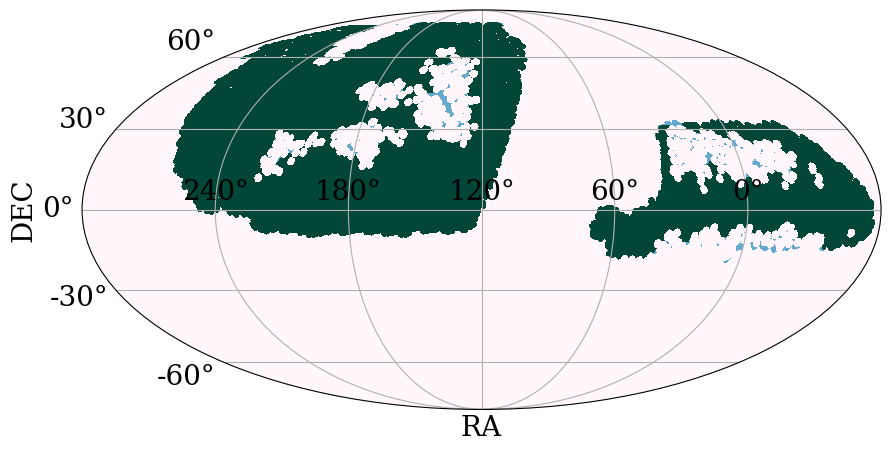

In [6]:
plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })
from matplotlib.lines import Line2D
#import matplotlib.patches as mpatches
compound_mask = ((mask['DONE']).astype(int)*.5 
                 + (mask_smoothed['DONE']).astype(int)*.5 
                )

fig = plt.figure(dpi=200)
projview(compound_mask, nest=True,rot=125, 
    fig = fig,
    fontsize={'xlabel':20,'ylabel':20,'xtick_label':20,'ytick_label':20},
    graticule=True,
    graticule_labels=True,
    cbar=False,
    cmap='PuBuGn',
    xlabel="RA",
    ylabel="DEC",
    custom_xtick_labels=["240°", "180°", "120°", "60°", "0°"],
    #custom_xtick_labels=[],
    custom_ytick_labels=["-60°", "-30°", "0°", "30°", "60°"],
    )


In [4]:
cut_mask = iron_mask['DONE'].astype(int)
num_px = len(cut_mask)
theta, phi = hp.pix2ang(hp.get_nside(cut_mask), np.arange(num_px), nest=True)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
select = (ra < 80) +  (ra > 300)
41252.96*np.sum(cut_mask[~select])/num_px, 41252.96*np.sum(cut_mask[select])/num_px

(2320.4501492818194, 385.82589981079104)

(2320.4501492818194, 385.82589981079104)

In [3]:
#open SDSS mask
with open("NSA_mask.pickle", 'rb') as temp_infile:
    mask_sdss, _, _ = pickle.load(temp_infile)

#turn SDSS mask into an outline
outline_sdss = (np.abs(np.diff(mask_sdss.astype(int),axis=1,prepend=0)) 
    + np.abs(np.diff(mask_sdss.astype(int),axis=0,prepend=0))
)
outline_sdss[outline_sdss!=0]=1

#convert sdss outline mask to healpix
sdss_ra, sdss_dec = hp.pix2ang(hp.npix2nside(len(iron_mask['DONE'])), iron_mask['HPXPIXEL'],lonlat=True,nest=True)
sdss_ra=sdss_ra.astype(int)
sdss_dec=sdss_dec.astype(int)+90
sdss=outline_sdss[sdss_ra,sdss_dec]
sdss=sdss.astype(bool)

In [4]:
#combine SDSS and DESI masks
compound_mask = ((iron_mask['DESI']*~(sdss+iron_mask['DONE'])).astype(int)*.33 
                 + (iron_mask['DONE']*~sdss).astype(int) * .66
                 + sdss.astype(int) * 1
                )


<Figure size 1280x960 with 0 Axes>

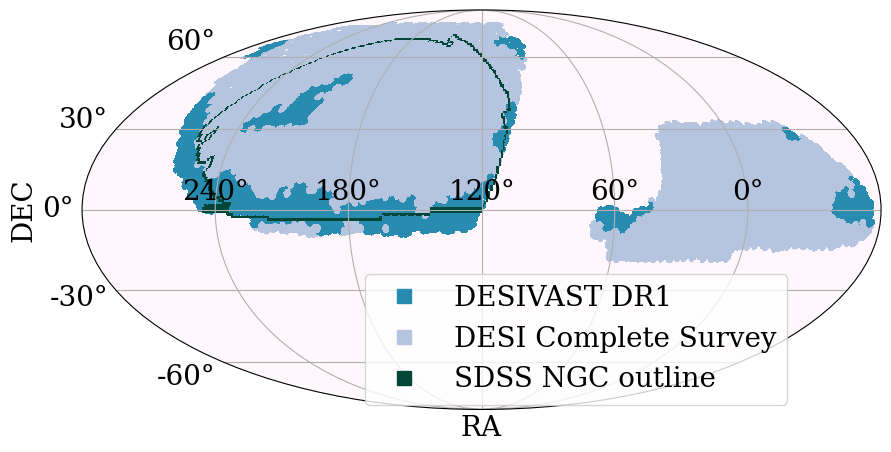

In [6]:
#plot the masks

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })
from matplotlib.lines import Line2D
#import matplotlib.patches as mpatches

fig = plt.figure(dpi=200)
projview(compound_mask, nest=True,rot=125, 
    fig = fig,
    fontsize={'xlabel':20,'ylabel':20,'xtick_label':20,'ytick_label':20},
    graticule=True,
    graticule_labels=True,
    cbar=False,
    cmap='PuBuGn',
    xlabel="RA",
    ylabel="DEC",
    custom_xtick_labels=["240°", "180°", "120°", "60°", "0°"],
    #custom_xtick_labels=[],
    custom_ytick_labels=["-60°", "-30°", "0°", "30°", "60°"],
    )

legend_elements = [Line2D([0], [0], marker='s', markersize=10, ls='', color='#288cb1',label='DESIVAST DR1'),
                   Line2D([0], [0], marker='s', markersize=10, ls='', color='#b5c4df',label='DESI Complete Survey'),
                   Line2D([0], [0], marker='s', markersize=10, ls='', color='#014636',label='SDSS NGC outline')]

plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(.9,.375));
plt.savefig("survey_comparison.png", bbox_inches = "tight", dpi=400)

<Figure size 1280x960 with 0 Axes>

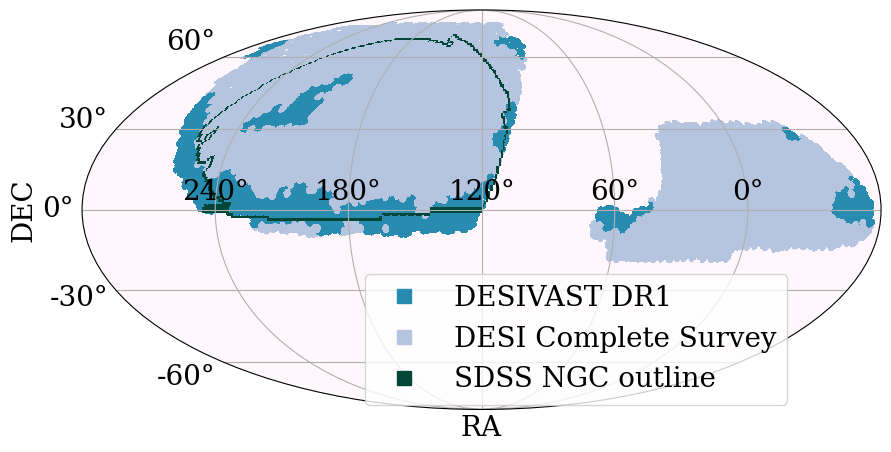

<Figure size 1280x960 with 0 Axes>

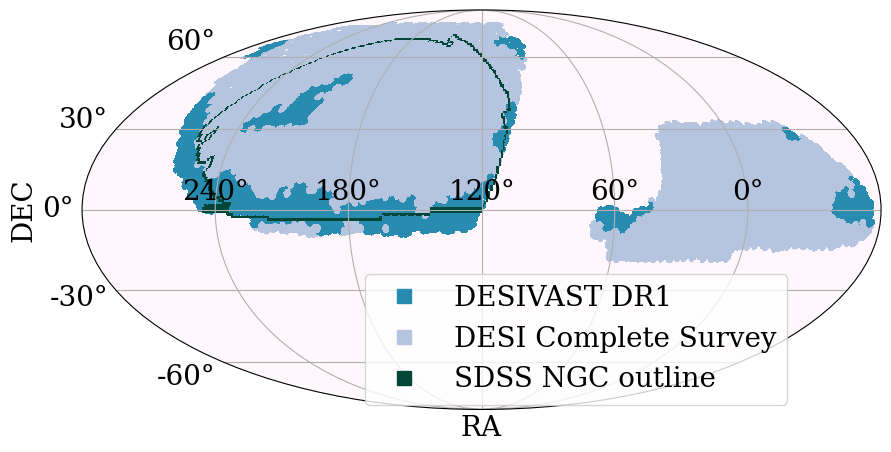

In [8]:
#plot the masks

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })
from matplotlib.lines import Line2D
#import matplotlib.patches as mpatches

fig = plt.figure(dpi=200)
projview(compound_mask, nest=True,rot=125, 
    fig = fig,
    fontsize={'xlabel':20,'ylabel':20,'xtick_label':20,'ytick_label':20},
    graticule=True,
    graticule_labels=True,
    cbar=False,
    cmap='PuBuGn',
    xlabel="RA",
    ylabel="DEC",
    custom_xtick_labels=["240°", "180°", "120°", "60°", "0°"],
    #custom_xtick_labels=[],
    custom_ytick_labels=["-60°", "-30°", "0°", "30°", "60°"],
    )

legend_elements = [Line2D([0], [0], marker='s', markersize=10, ls='', color='#288cb1',label='DESIVAST DR1'),
                   Line2D([0], [0], marker='s', markersize=10, ls='', color='#b5c4df',label='DESI Complete Survey'),
                   Line2D([0], [0], marker='s', markersize=10, ls='', color='#014636',label='SDSS NGC outline')]

plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(.9,.375));
plt.savefig("survey_comparison.png", bbox_inches = "tight")

In [8]:
#save DMP output

dmp_path = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/DESIVAST_figures.fits'
dmp_file = open_fits_file(dmp_path)
hdu = fits.BinTableHDU(Table([compound_mask],names=['MASK']))
hdu.name = 'FIG2'
hdu.header['EXCLUDE'] = (0.0, 'Excluded healpix pixels')
hdu.header['DESIY5'] = (0.33, 'DESI complete healpix pixels')
hdu.header['DESIDR1'] = (0.66, 'DESIVAST DR1 healpix pixels')
hdu.header['SDSS'] = (1.0, 'SDSS NGC outline healpix pixels')
dmp_file.append(hdu)
dmp_file.writeto(dmp_path, overwrite=True)
